# 过拟合与欠拟合
本篇讨论一个机器学习中最基本的理论，过拟合与欠拟合，力图用最直白的语言来阐述。    
`` Tips: 深度学习是机器学习的子集，机器学习又是人工智能化的子集。    
本篇会重点讨论什么是过拟合和欠拟合，具体表现，解决方法，以及结合多项式拟合给出具体的实验结果。

## 1. 训练集、测试集、验证集
任何一个机器学习任务，我们都需要收集许多样本，比如在企业中经常要处理的CTR预估模型，用户没有点击过的是负样本，用户点击过的是正样本（不过实际中常常用随机的方法选择正样本），然后我们学习得到我们的模型，但是模型一定是应用到我们没有见过的样本上面的，这些样本就是测试集。实际中在机器学习过程中不可能看到测试样本，所以我们常常通过一种方法来模拟出测试样本，也就是验证集。通常，我们将样本分成N分，拿其中N-1份当做训练集，剩余一份当做测试集，然后求N份分别当测试集的效果的平均值，来模拟我们在真实情况下的误差。这种方法称为N择交叉验证法。最后将模型应用的线上，观测实际效果。

注意：后文说的测试集都是验证测试集合，是从训练样本中取出一部分的集合，欠拟合和过拟合都指的是训练集和验证测试集上的表现。如果验证集表现不错，但实际线上效果很差，这个很有可能是样本构造或者特征处理没有对齐，后面专门讲解如何处理此类情况。

## 2. 过拟合和欠拟合通俗理解
### 2.1 过拟合
+ 具体表现：模型在训练集的误差远远好过在测试集上的表现
+ 解决方法：常见的方法有，正则化、DropOut、增加训练样本、选择复杂度更低的模型、提前终止学习

### 2.2 欠拟合
+ 具体表现：模型在训练集的误差很高
+ 解决方法：常见的方法有，选择复杂度更高的模型、增加学习次数

## 3. 实际案例讲解
下面结合多项式拟合的案例来说明过拟合和迁拟合的具体表现，已经解决的方法。首先需要生成模拟样本。我们假定训练样本和测试样本均是按如下公式生成：y=1.2x-3.4x^2+5.6x^3+5+sigma，其中sigma是服从均值为0，方差为0.01的正态分布。暂时先假设训练样本和测试样本的数量都是100。

In [1]:
import torch
import numpy as np
n_tain = 100
n_test = 100
feature = torch.randn(200, 1)
# 按列组合在一起
true_x = torch.cat((feature, torch.pow(feature, 2), torch.pow(feature, 3)), 1)
true_y = 1.2*feature - 3.4*torch.pow(feature, 2) + 5.6*torch.pow(feature, 3) + 5 + torch.tensor(np.random.normal(0.0, 0.01, size=(200, 1)), dtype=torch.float)

In [2]:
print(true_x[0:2])
print(true_y[:2])

tensor([[ 1.0176,  1.0355,  1.0538],
        [-0.4359,  0.1900, -0.0829]])
tensor([[8.6013],
        [3.3800]])


### 3.1 模型定义
本篇继续利用 Pytorch Lighting 来定义模型

In [3]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import pytorch_lightning as pl
import numpy as np

class PolyModel(pl.LightningModule):

    def __init__(self, linear_layer, traind, testd):
        super(PolyModel, self).__init__()
        self.l1 = linear_layer
        self.epoch_valid_loss = []
        self.epoch_train_loss = []
        self.traind = traind
        self.testd = testd

    def forward(self, x):
        return self.l1(x)

    def training_step(self, batch, batch_idx):
        # 必须提供：定于训练过程
        x, y = batch
        y_hat = self.forward(x)
        loss = F.mse_loss(y_hat, y)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}

    def training_epoch_end(self, outputs):
        # 结束一轮训练，自测一下
        x, y = iter(self.traind).next()
        y_hat = self.forward(x)
        train_loss = F.mse_loss(y_hat, y)
        self.epoch_train_loss.append(train_loss.item())
        tensorboard_logs = {'train_loss': train_loss}
        return {'loss': train_loss, 'log': tensorboard_logs, 'progress_bar': tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        # 可选提供：定义测试过程
        x, y = batch
        y_hat = self.forward(x)
        loss = F.mse_loss(y_hat, y)
        tensorboard_logs = {'valid_loss': loss}
        return {'val_loss': loss, 'log': tensorboard_logs, 'progress_bar': tensorboard_logs}

    def validation_epoch_end(self, outputs):
        # 可选提供：定义验证过程，验证集上效果，每轮都会验证
        avg_val_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        self.epoch_valid_loss.append(avg_val_loss.item())
        tensorboard_logs = {'valid_loss': avg_val_loss}
        return {'val_loss': avg_val_loss, 'log': tensorboard_logs, 'progress_bar': tensorboard_logs}

    def configure_optimizers(self):
        # 必须提供：定义优化器
        # can return multiple optimizers and learning_rate schedulers
        # (LBFGS it is automatically supported, no need for closure function)
        return torch.optim.SGD(self.parameters(), lr=0.01)

    def train_dataloader(self):
        # 必须提供：提供训练数据集
        return self.traind

    def val_dataloader(self):
        # 可选提供：提供测试数据集
        return self.testd

In [14]:
# 训练集用全部数据，模型拟合3次函数
train_dataloader = DataLoader(TensorDataset(true_x[:100], true_y[:100]), batch_size=10, shuffle=True, num_workers=0)
test_dataloader = DataLoader(TensorDataset(true_x[100:], true_y[100:]), batch_size=100, shuffle=False, num_workers=0)
poly_model = PolyModel(torch.nn.Linear(3, 1), train_dataloader, test_dataloader)
trainer = pl.Trainer(logger=False, max_epochs=50, num_sanity_val_steps=0, progress_bar_refresh_rate=0)
trainer.fit(poly_model)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 4     


1

Parameter containing:
tensor([[ 1.2876, -3.3654,  5.5698]], requires_grad=True)
Parameter containing:
tensor([4.9590], requires_grad=True)


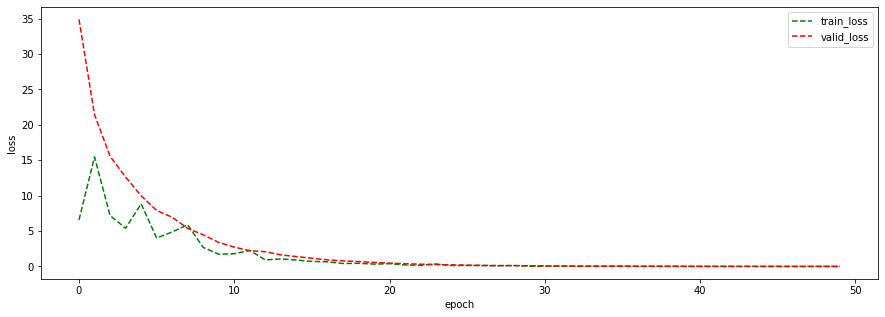

In [16]:
# 打印所有参数 y=1.2x-3.4x^2+5.6x^3+5+sigma
for i in poly_model.parameters():
    print(i)
import matplotlib.pyplot as plt  
def plot_epoch_loss(train_loss_list, test_loss_list):
    x_vals = list(range(len(train_loss_list)))
    plt.figure(figsize=(15, 5))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(x_vals, train_loss_list, 'g--',label='train_loss')
    plt.plot(x_vals, test_loss_list, 'r--',label='valid_loss')
    plt.legend()
    plt.show()

plot_epoch_loss(poly_model.epoch_train_loss, poly_model.epoch_valid_loss)



可以看出训练集误差和验证测试集误差均越来越小，最终都靠近0，模型很好的学到了训练集的特征，并且成功应用到验证测试集，也保持通用好的效果。

### 3.2 用简单模型拟合复杂模型-模拟欠拟合

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 2     


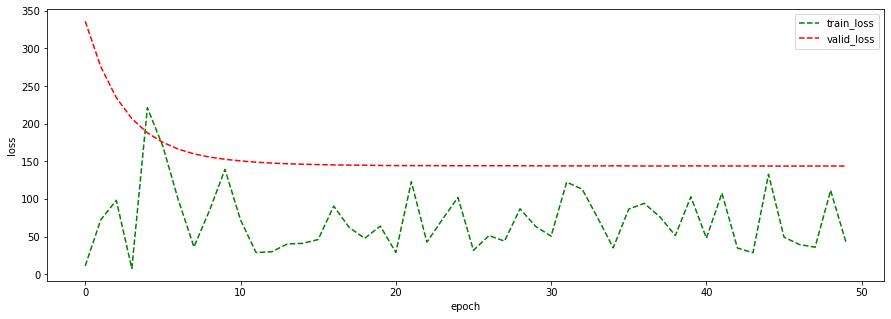

In [21]:
# 训练集用全部数据，模型拟合1次函数
train_dataloader = DataLoader(TensorDataset(feature[:100], true_y[:100]), batch_size=10, shuffle=True, num_workers=0)
test_dataloader = DataLoader(TensorDataset(feature[100:], true_y[100:]), batch_size=100, shuffle=False, num_workers=0)
poly_model2 = PolyModel(torch.nn.Linear(1, 1), train_dataloader, test_dataloader)
trainer = pl.Trainer(max_epochs=50, num_sanity_val_steps=0, progress_bar_refresh_rate=0)
trainer.fit(poly_model2)
plot_epoch_loss(poly_model2.epoch_train_loss, poly_model2.epoch_valid_loss)

可以看出训练集误差和验证测试集误差都一直比较大，模型没法从数据中根本学不到东西。一般发生欠拟合，我们通常通过下面的手段去解决：
+ 增加训练迭代次数
+ 增加模型复杂度

### 3.3 用少量样本训练模型-模拟过拟合

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 4     


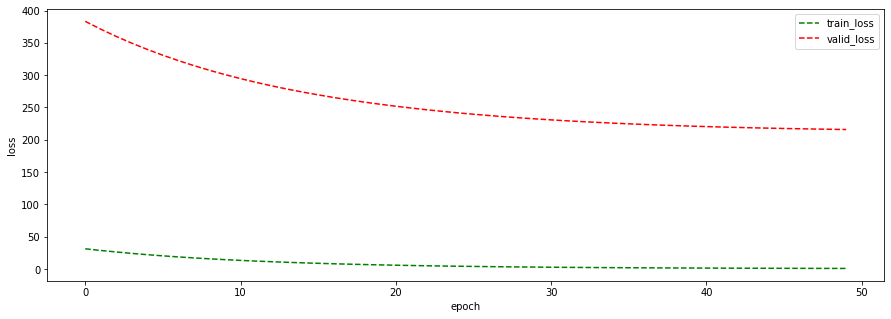

In [22]:
# 训练集用2个样本数据，模型拟合3次函数
train_dataloader = DataLoader(TensorDataset(true_x[:2], true_y[:2]), batch_size=10, shuffle=True, num_workers=0)
test_dataloader = DataLoader(TensorDataset(true_x[100:], true_y[100:]), batch_size=100, shuffle=False, num_workers=0)
poly_model3 = PolyModel(torch.nn.Linear(3, 1), train_dataloader, test_dataloader)
trainer = pl.Trainer(max_epochs=50, num_sanity_val_steps=0, progress_bar_refresh_rate=0)
trainer.fit(poly_model3)
plot_epoch_loss(poly_model3.epoch_train_loss, poly_model3.epoch_valid_loss)

可以看出训练集的误差很快就降到0附近，但是验证测试集的误差一直都很大，模型的泛化性很差。一般出现模型过拟合，我们可以通过以下手段去解决：
+ 增加训练数量 => 实际上案例就是通过增加训练集数量即可解决过拟合
+ 降低模型复杂度
+ 增加正则化
+ 提前停止训练
+ dropout     
不过正则化和样本数量通常是相互作用的，样本数量越多，正则化效果越差。

后面我们会通过过拟合处理章节来系统的学习如何处理过拟合。
